In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer

import pymorphy2
from nltk.corpus import stopwords
import logging
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
data_positive = pd.read_csv("Russian_Twitter_Sentiment/positive.csv", sep=';', header=None)
data_negative = pd.read_csv("Russian_Twitter_Sentiment/negative.csv", sep=';', header=None)
print(data_positive.shape)
print(data_negative.shape)

(114911, 12)
(111923, 12)


In [91]:
data_positive.head()

0           1                2   \
0  408906692374446080  1386325927  pleease_shut_up   
1  408906692693221377  1386325927  alinakirpicheva   
2  408906695083954177  1386325927        EvgeshaRe   
3  408906695356973056  1386325927    ikonnikova_21   
4  408906761416867842  1386325943        JumpyAlex   

                                                  3   4   5   6   7      8   \
0  @first_timee —Ö–æ—Ç—å —è –∏ —à–∫–æ–ª–æ—Ç–∞, –Ω–æ –ø–æ–≤–µ—Ä—å, —É –Ω–∞...   1   0   0   0   7569   
1  –î–∞, –≤—Å–µ-—Ç–∞–∫–∏ –æ–Ω –Ω–µ–º–Ω–æ–≥–æ –ø–æ—Ö–æ–∂ –Ω–∞ –Ω–µ–≥–æ. –ù–æ –º–æ–π ...   1   0   0   0  11825   
2  RT @KatiaCheh: –ù—É —Ç—ã –∏–¥–∏–æ—Ç–∫–∞) —è –∏—Å–ø—É–≥–∞–ª–∞—Å—å –∑–∞ ...   1   0   1   0   1273   
3  RT @digger2912: "–ö—Ç–æ —Ç–æ –≤ —É–≥–ª—É —Å–∏–¥–∏—Ç –∏ –ø–æ–≥–∏–±–∞–µ...   1   0   1   0   1549   
4  @irina_dyshkant –í–æ—Ç —á—Ç–æ –∑–Ω–∞—á–∏—Ç —Å—Ç—Ä–∞—à–∏–ª–∫–∞ :D\n–ù...   1   0   0   0    597   

   9   10  11  
0  62  61   0  
1  59  31   2  
2  26  27   0  
3  19  17   0  
4  16  23   1

In [92]:
data_positive = data_positive.drop(data_positive[[0,1,2,5,6,7,8,9,10,11]],axis=1) # —É–¥–∞–ª—è–µ–º—ã–µ –∏–Ω–¥–µ–∫—Å—ã, axis=1 - —É —Å—Ç–æ–ª–±—Ü–æ–≤
data_negative = data_negative.drop(data_negative[[0,1,2,5,6,7,8,9,10,11]],axis=1)
data_positive.columns=['comment', 'label']
data_negative.columns=['comment', 'label']
data_positive.head()

comment  label
0  @first_timee —Ö–æ—Ç—å —è –∏ —à–∫–æ–ª–æ—Ç–∞, –Ω–æ –ø–æ–≤–µ—Ä—å, —É –Ω–∞...      1
1  –î–∞, –≤—Å–µ-—Ç–∞–∫–∏ –æ–Ω –Ω–µ–º–Ω–æ–≥–æ –ø–æ—Ö–æ–∂ –Ω–∞ –Ω–µ–≥–æ. –ù–æ –º–æ–π ...      1
2  RT @KatiaCheh: –ù—É —Ç—ã –∏–¥–∏–æ—Ç–∫–∞) —è –∏—Å–ø—É–≥–∞–ª–∞—Å—å –∑–∞ ...      1
3  RT @digger2912: "–ö—Ç–æ —Ç–æ –≤ —É–≥–ª—É —Å–∏–¥–∏—Ç –∏ –ø–æ–≥–∏–±–∞–µ...      1
4  @irina_dyshkant –í–æ—Ç —á—Ç–æ –∑–Ω–∞—á–∏—Ç —Å—Ç—Ä–∞—à–∏–ª–∫–∞ :D\n–ù...      1

In [93]:
fault = 11000
max_comments = 100000
data_positive = data_positive[:int((max_comments + fault) / 2)] # –ø–µ—Ä–µ–∑–∞–ø–∏—Å—ã–≤–∞–µ–º df
data_negative = data_negative[:int((max_comments + fault) / 2)] # –ø–µ—Ä–µ–∑–∞–ø–∏—Å—ã–≤–∞–µ–º df
print(data_positive.shape)
print(data_negative.shape)

(55500, 2)
(55500, 2)


In [94]:
def clean_data(comment):
    clean_pattern = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~‚Äî\"\-\n\‚Äú\‚Äù]+"
    comment = re.sub(clean_pattern, ' ', comment)
    clean_pattern = "[^–ê-–Ø–∞-—è\sA-Za-z]" # –¥–ª—è —É–¥–∞–ª–µ–Ω–∏—è emoji
    comment = re.sub(clean_pattern, ' ', comment)
    return comment

data_positive['comment'] = data_positive['comment'].apply(clean_data)
data_negative['comment'] = data_negative['comment'].apply(clean_data)

data_positive.head()

comment  label
0    —Ö–æ—Ç—å —è –∏ —à–∫–æ–ª–æ—Ç–∞  –Ω–æ –ø–æ–≤–µ—Ä—å  —É –Ω–∞—Å —Ç–æ –∂–µ —Å–∞–º...      1
1  –î–∞  –≤—Å–µ —Ç–∞–∫–∏ –æ–Ω –Ω–µ–º–Ω–æ–≥–æ –ø–æ—Ö–æ–∂ –Ω–∞ –Ω–µ–≥–æ  –ù–æ –º–æ–π ...      1
2               –ù—É —Ç—ã –∏–¥–∏–æ—Ç–∫–∞  —è –∏—Å–ø—É–≥–∞–ª–∞—Å—å –∑–∞ —Ç–µ–±—è       1
3       –ö—Ç–æ —Ç–æ –≤ —É–≥–ª—É —Å–∏–¥–∏—Ç –∏ –ø–æ–≥–∏–±–∞–µ—Ç –æ—Ç –≥–æ–ª–æ–¥–∞ ...      1
4    –í–æ—Ç —á—Ç–æ –∑–Ω–∞—á–∏—Ç —Å—Ç—Ä–∞—à–∏–ª–∫–∞  –ù–æ –±–ª–∏–Ω –ø–æ—Å–º–æ—Ç—Ä–µ–≤ ...      1

In [3]:
stopwords = stopwords.words("russian")
pymorph = pymorphy2.MorphAnalyzer()

def to_normal_form(comment):
    comment = comment.split() # –†–∞–∑–¥–µ–ª—è–µ–º –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –Ω–∞ —Å–ª–æ–≤–∞
    tokens = []
    for token in comment:
        if token and token not in stopwords:
            token = token.strip() # —É–¥–∞–ª—è–µ–º –ª–∏—à–Ω–∏–µ –ø—Ä–æ–±–µ–ª—ã –≤ —Ç–æ–∫–µ–Ω–µ
            token = pymorph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [96]:
data_positive['comment'] = data_positive['comment'].apply(to_normal_form)
data_negative['comment'] = data_negative['comment'].apply(to_normal_form)
data_positive = data_positive.dropna() 
data_negative = data_negative.dropna() # —É–¥–∞–ª–∏—Ç—å None —Å—Ç—Ä–æ–∫–∏

In [97]:
data_positive.head()

comment  label
0  [—à–∫–æ–ª–æ—Ç—ã–π, –ø–æ–≤–µ—Ä—å, —Å–∞–º—ã–π, –æ–±—â–µ—Å—Ç–≤–æ, –ø—Ä–æ—Ñ–∏–ª–∏—Ä–æ–≤...      1
1   [–¥–∞, —Ç–∞–∫–∏, –Ω–µ–º–Ω–æ–≥–æ, –ø–æ—Ö–æ–∂–∏–π, –Ω–æ, –º–∞–ª—å—á–∏–∫, —Ä–∞–≤–Ω–æ]      1
2                          [–Ω—É, –∏–¥–∏–æ—Ç–∫–∞, –∏—Å–ø—É–≥–∞—Ç—å—Å—è]      1
3  [–∫—Ç–æ, —É–≥–æ–ª, —Å–∏–¥–µ—Ç—å, –ø–æ–≥–∏–±–∞—Ç—å, –≥–æ–ª–æ–¥, –µ—â, –ø–æ—Ä—Ü–∏...      1
4  [–≤–æ—Ç, –∑–Ω–∞—á–∏—Ç, —Å—Ç—Ä–∞—à–∏–ª–∫–∞, –Ω–æ, –±–ª–∏–Ω, –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å,...      1

In [98]:
data_negative.head()

comment  label
0  [—Ä–∞–±–æ—Ç–∞, –ø–æ–ª–Ω—ã–π, –ø–∏–¥–¥–µ—Å, –∫–∞–∂–¥—ã–π, –∑–∞–∫—Ä—ã—Ç–∏–µ, –º–µ—Å...     -1
1   [–∫–æ–ª–ª–µ–≥–∞, —Å–∏–¥–µ—Ç—å, —Ä—É–±–∏—Ç—å—Å—è, –¥–æ–ª–±–∞—Ç—å, –≤–∏–Ω–¥, –º–æ—á—å]     -1
2                   [–≥–æ–≤–æ—Ä–∏—Ç—å, –æ–±–µ—â–∞–Ω–æ–π, –≥–æ–¥, –∂–¥–∞—Ç—å]     -1
3  [–∂–µ–ª–∞—Ç—å, —Ö–æ—Ä–æ—à–∏–π, –ø–æ–ª, —Ç–æ—Ç, —É–¥–∞—á–Ω—ã–π, –ø–æ—Å–∞–¥–∫–∞, ...     -1
4    [–æ–±–Ω–æ–≤–∏—Ç—å, –∫–∞–∫–æ–π, –ª–µ—à–∏–π, —Ä–∞–±–æ—Ç–∞—Ç—å, –ø—Ä–æ—Å—Ç–æ–ø–ª–µ–µ—Ä]     -1

In [99]:
print(data_positive.shape)
print(data_negative.shape)

(52902, 2)
(52139, 2)


In [100]:
data_positive = data_positive[:int(max_comments / 2)] # –ø–µ—Ä–µ–∑–∞–ø–∏—Å—ã–≤–∞–µ–º df
data_negative = data_negative[:int(max_comments / 2)] # –ø–µ—Ä–µ–∑–∞–ø–∏—Å—ã–≤–∞–µ–º df
print(data_positive.shape)
print(data_negative.shape)

(50000, 2)
(50000, 2)


In [101]:
all_data = pd.concat([data_positive, data_negative]) # –∫–æ–Ω–∫–∞—Ç–µ–Ω–∞—Ü–∏—è df-–æ–≤
print(all_data.shape)

all_data = shuffle(all_data) # –ø–µ—Ä–µ–º–µ—à–∏–≤–∞–µ–º df
all_data.reset_index(drop=True, inplace=True) # –æ–±–Ω–æ–≤–ª—è–µ–º –∏–Ω–¥–µ–∫—Å—ã
all_data.head()

(100000, 2)


comment  label
0                          [–ø—Ä–∏–º–µ—Ä–Ω–æ, –≥—Ä–Ω, –¥–æ—Ä–æ–≥–æ–π]     -1
1  [–∞, –≤–æ–≤–∞, –Ω–∞–æ–±–æ—Ä–æ—Ç, –≤–æ–∑–º—É—â–∞—Ç—å—Å—è, –ø–æ—á–µ–º—É, –ø–∏—Å–∞—Ç—å]     -1
2          [–±–∞–±–∞, –∫–∞—Ç—è, –ø–æ–ø—ã—Ç–∫–∞, –∫–∞–∑–∞—Ç—å—Å—è, –≥—Ä–æ–∑–Ω—ã–π]      1
3            [–≤—ã—Ö–æ–¥–Ω–æ–π, –ø–æ–¥—Ä—è–¥, –ø—Ä–æ—Ö–æ–¥–∏—Ç—å, –æ—Ç–ª–∏—á–Ω–æ]      1
4  [–º—ã, —Å–µ–≥–æ–¥–Ω—è, —É—Ö–∞, –ø—Ä–∏—è—Ç–Ω—ã–π, –∞–ø–ø–µ—Ç–∏—Ç, –µ–¥–∏–Ω–æ–µ–¥–µ—Ü]      1

<AxesSubplot:xlabel='label', ylabel='count'>

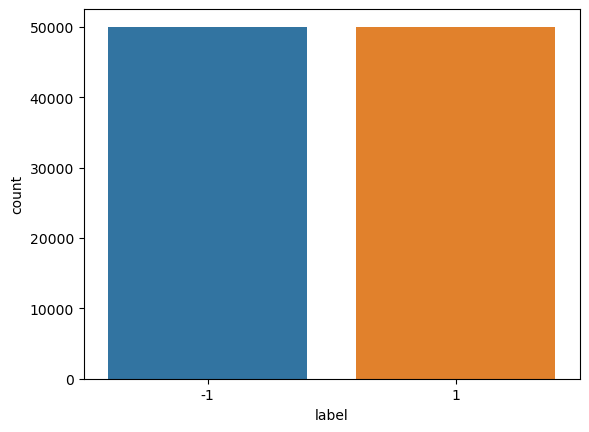

In [102]:
sns.countplot(x='label', data=all_data)

In [103]:
print(all_data['comment'][0])

['–ø—Ä–∏–º–µ—Ä–Ω–æ', '–≥—Ä–Ω', '–¥–æ—Ä–æ–≥–æ–π']


In [104]:
# –ó–∞–ø–∏—Å–∞—Ç—å csv –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –±—ã—Å—Ç—Ä–æ–≥–æ –¥–æ—Å—É—Ç–ø–∞ –∫ –¥–∞–Ω–Ω—ã–º

def csv_comment(comment):
    comment = ' '.join(comment)
    return comment

data_to_write = all_data
data_to_write['comment'] = data_to_write['comment'].apply(csv_comment)
data_to_write.to_csv("Russian_Twitter_Sentiment/clear_data_frame100k(last).csv", index=False)

In [105]:
data_to_write.head()

comment  label
0                       –ø—Ä–∏–º–µ—Ä–Ω–æ –≥—Ä–Ω –¥–æ—Ä–æ–≥–æ–π     -1
1  –∞ –≤–æ–≤–∞ –Ω–∞–æ–±–æ—Ä–æ—Ç –≤–æ–∑–º—É—â–∞—Ç—å—Å—è –ø–æ—á–µ–º—É –ø–∏—Å–∞—Ç—å     -1
2         –±–∞–±–∞ –∫–∞—Ç—è –ø–æ–ø—ã—Ç–∫–∞ –∫–∞–∑–∞—Ç—å—Å—è –≥—Ä–æ–∑–Ω—ã–π      1
3          –≤—ã—Ö–æ–¥–Ω–æ–π –ø–æ–¥—Ä—è–¥ –ø—Ä–æ—Ö–æ–¥–∏—Ç—å –æ—Ç–ª–∏—á–Ω–æ      1
4  –º—ã —Å–µ–≥–æ–¥–Ω—è —É—Ö–∞ –ø—Ä–∏—è—Ç–Ω—ã–π –∞–ø–ø–µ—Ç–∏—Ç –µ–¥–∏–Ω–æ–µ–¥–µ—Ü      1

In [ ]:
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü

In [106]:
def split_comments(comment):
    comment = comment.split()
    return comment

all_data = pd.read_csv("Russian_Twitter_Sentiment/clear_data_frame100k(last).csv")
all_data['comment'] = all_data['comment'].apply(split_comments)

In [107]:
all_data.head()

comment  label
0                          [–ø—Ä–∏–º–µ—Ä–Ω–æ, –≥—Ä–Ω, –¥–æ—Ä–æ–≥–æ–π]     -1
1  [–∞, –≤–æ–≤–∞, –Ω–∞–æ–±–æ—Ä–æ—Ç, –≤–æ–∑–º—É—â–∞—Ç—å—Å—è, –ø–æ—á–µ–º—É, –ø–∏—Å–∞—Ç—å]     -1
2          [–±–∞–±–∞, –∫–∞—Ç—è, –ø–æ–ø—ã—Ç–∫–∞, –∫–∞–∑–∞—Ç—å—Å—è, –≥—Ä–æ–∑–Ω—ã–π]      1
3            [–≤—ã—Ö–æ–¥–Ω–æ–π, –ø–æ–¥—Ä—è–¥, –ø—Ä–æ—Ö–æ–¥–∏—Ç—å, –æ—Ç–ª–∏—á–Ω–æ]      1
4  [–º—ã, —Å–µ–≥–æ–¥–Ω—è, —É—Ö–∞, –ø—Ä–∏—è—Ç–Ω—ã–π, –∞–ø–ø–µ—Ç–∏—Ç, –µ–¥–∏–Ω–æ–µ–¥–µ—Ü]      1

In [108]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

In [109]:
def train_w2v_model(data):
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    
    model = Word2Vec(
        min_count = 10, # –°–ª–æ–≤–∞ –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ä–µ—á–∞—é—Ç—Å—è –≤ —Å–ª–æ–≤–∞—Ä–µ –º–µ–Ω–µ–µ 10 —Ä–∞–∑ –∏–≥–Ω–æ—Ä–∏—Ä—É–µ–º
        window = 2, # –°–∫–æ–ª—å–∫–æ —Å–ª–æ–≤ –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞, –∫–æ—Ç–æ—Ä—ã–µ –¥–æ–ª–∂–µ–Ω —É—á–∏—Ç—ã–≤–∞—Ç—å –∞–ª–≥–æ—Ä–∏—Ç–º
        vector_size = 300, # –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –≤–µ–∫—Ç–æ—Ä–∞ —Å–ª–æ–≤–∞(–ë–æ–ª—å—à–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ = –º–Ω–æ–≥–æ –æ–±—É—á–∞—é—â–∏—Ö –¥–∞–Ω–Ω—ã—Ö)
        workers = cpu_count(), # –ú–Ω–æ–≥–æ–ø–æ—Ç–æ—á–Ω–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è
        sample=1e-3, # –ü–æ–Ω–∏–∂–∞—é—â–∞—è –¥–∏—Å–∫—Ä–µ—Ç–∏–∑–∞—Ü–∏—è –¥–ª—è –≤—ã—Å–æ–∫–æ—á–∞—Å—Ç–æ—Ç–Ω—ã—Ö —Å–ª–æ–≤ (—Å—Ä–µ–¥–Ω–µ–µ —Ä–µ–∫–æ–º–µ–Ω–¥–æ–≤–∞–Ω–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ)
        sg = 1 # –µ—Å–ª–∏ 1, —Ç–æ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—è Skip-gram(–±–æ–ª–µ–µ —Ç–æ—á–Ω—ã–π); –µ—Å–ª–∏ 0, —Ç–æ CBOW(–±–æ–ª–µ–µ –±—ã—Å—Ç—Ä—ã–π).
        )
    
    model.build_vocab(data)
    
    print('–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ Word2Vec ...')
    model.train(data, total_examples=model.corpus_count, epochs=30, report_delay=1)
    
    return model

In [110]:
data = all_data['comment']
print(data[9506])

['–∞—Ö–∞—Ö–∏', '–±–µ—Å–∏—Ç—å—Å—è', '–¥–æ–º', '—Å–∏–¥–µ—Ç—å', '–≤–∫']


In [111]:
model = train_w2v_model(data)

2023-05-03 14:32:51,950 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2023-05-03T14:32:51.950935', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
2023-05-03 14:32:51,951 : INFO : collecting all words and their counts
2023-05-03 14:32:51,952 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-05-03 14:32:51,974 : INFO : PROGRESS: at sentence #10000, processed 74168 words, keeping 15540 word types
2023-05-03 14:32:51,997 : INFO : PROGRESS: at sentence #20000, processed 148985 words, keeping 23648 word types
2023-05-03 14:32:52,025 : INFO : PROGRESS: at sentence #30000, processed 223463 words, keeping 29925 word types
2023-05-03 14:32:52,051 : INFO : PROGRESS: at sentence #40000, processed 297422 words, keeping 35342 word types
2023-05-03 14:32:52,077 : INFO : PROGRESS: at sentence #50000

–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ Word2Vec ...


2023-05-03 14:32:53,299 : INFO : worker thread finished; awaiting finish of 7 more threads
2023-05-03 14:32:53,305 : INFO : worker thread finished; awaiting finish of 6 more threads
2023-05-03 14:32:53,311 : INFO : worker thread finished; awaiting finish of 5 more threads
2023-05-03 14:32:53,318 : INFO : worker thread finished; awaiting finish of 4 more threads
2023-05-03 14:32:53,320 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-05-03 14:32:53,321 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-05-03 14:32:53,324 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-05-03 14:32:53,338 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-05-03 14:32:53,338 : INFO : EPOCH - 1 : training on 742440 raw words (595897 effective words) took 0.9s, 654296 effective words/s
2023-05-03 14:32:54,121 : INFO : worker thread finished; awaiting finish of 7 more threads
2023-05-03 14:32:54,123 : INFO : worker thread

2023-05-03 14:33:00,418 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-05-03 14:33:00,426 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-05-03 14:33:00,433 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-05-03 14:33:00,434 : INFO : EPOCH - 10 : training on 742440 raw words (595922 effective words) took 0.7s, 797456 effective words/s
2023-05-03 14:33:01,188 : INFO : worker thread finished; awaiting finish of 7 more threads
2023-05-03 14:33:01,200 : INFO : worker thread finished; awaiting finish of 6 more threads
2023-05-03 14:33:01,202 : INFO : worker thread finished; awaiting finish of 5 more threads
2023-05-03 14:33:01,204 : INFO : worker thread finished; awaiting finish of 4 more threads
2023-05-03 14:33:01,209 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-05-03 14:33:01,217 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-05-03 14:33:01,225 : INFO : worker threa

2023-05-03 14:33:08,282 : INFO : worker thread finished; awaiting finish of 6 more threads
2023-05-03 14:33:08,288 : INFO : worker thread finished; awaiting finish of 5 more threads
2023-05-03 14:33:08,290 : INFO : worker thread finished; awaiting finish of 4 more threads
2023-05-03 14:33:08,291 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-05-03 14:33:08,300 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-05-03 14:33:08,308 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-05-03 14:33:08,322 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-05-03 14:33:08,323 : INFO : EPOCH - 20 : training on 742440 raw words (595901 effective words) took 0.8s, 749999 effective words/s
2023-05-03 14:33:09,033 : INFO : worker thread finished; awaiting finish of 7 more threads
2023-05-03 14:33:09,035 : INFO : worker thread finished; awaiting finish of 6 more threads
2023-05-03 14:33:09,045 : INFO : worker threa

2023-05-03 14:33:15,278 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-05-03 14:33:15,281 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-05-03 14:33:15,281 : INFO : EPOCH - 29 : training on 742440 raw words (595686 effective words) took 0.7s, 840320 effective words/s
2023-05-03 14:33:16,034 : INFO : worker thread finished; awaiting finish of 7 more threads
2023-05-03 14:33:16,042 : INFO : worker thread finished; awaiting finish of 6 more threads
2023-05-03 14:33:16,045 : INFO : worker thread finished; awaiting finish of 5 more threads
2023-05-03 14:33:16,053 : INFO : worker thread finished; awaiting finish of 4 more threads
2023-05-03 14:33:16,058 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-05-03 14:33:16,060 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-05-03 14:33:16,064 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-05-03 14:33:16,083 : INFO : worker threa

In [112]:
# –°–û—Ö—Ä–∞–Ω—è–µ–º –≤–µ–∫—Ç–æ—Ä—ã —Å–ª–æ–≤ 

from gensim.models import KeyedVectors
word_vectors = model.wv
word_vectors.save(r"Russian_Twitter_Sentiment/word2vec.wordvectors")

2023-05-03 14:33:36,962 : INFO : KeyedVectors lifecycle event {'fname_or_handle': 'Russian_Twitter_Sentiment/word2vec.wordvectors', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-03T14:33:36.962902', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'saving'}
2023-05-03 14:33:36,980 : INFO : saved Russian_Twitter_Sentiment/word2vec.wordvectors


In [7]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –≤–µ–∫—Ç–æ—Ä—ã —Å–ª–æ–≤
from gensim.models import KeyedVectors
wv = KeyedVectors.load(r"Russian_Twitter_Sentiment/word2vec.wordvectors", mmap='r')

In [8]:
wv.most_similar(['—É–º–Ω–∏—Ü–∞'])

[('–æ—á–∏–Ω—å', 0.41544538736343384),
 ('—É—Å—Ç–∞', 0.4089416563510895),
 ('–ø–ª—é—à–µ–≤—ã–π', 0.40261945128440857),
 ('–ø–æ–ª—é–±–æ–º–∞', 0.3857073187828064),
 ('—É–≥–≥–∞', 0.385501503944397),
 ('–±–æ–º–±–∏—Ç—å', 0.3700158894062042),
 ('–ø—Ä–∏–Ω—Ü–µ—Å—Å–∞', 0.3641073703765869),
 ('–ø—É–ø—Å–∏–∫', 0.36311018466949463),
 ('—Å–ª–∞–¥–∫–æ', 0.3554232120513916),
 ('–æ—É—É', 0.35276418924331665)]

In [9]:
wv.doesnt_match("–≤–æ–¥–∏—Ç–µ–ª—å –∞–≤—Ç–æ–±—É—Å –∂–µ–Ω—â–∏–Ω–∞".split())

'–∂–µ–Ω—â–∏–Ω–∞'

In [13]:
# data = pd.read_csv("Russian_Twitter_Sentiment/clear_data_frame.csv")
# comments_data = data['comment']
# comments_data.head()
# print(comments_data[0])

# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(analyzer = "word", tokenizer=None,
#                               preprocessor=None, stop_words = None,
#                               max_features=1000)

# # –ò–∑—É—á–∞–µ–º —Å–ª–æ–≤–∞—Ä–Ω—ã–π –∑–∞–ø–∞—Å —Å–ª–æ–≤–∞—Ä—è –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ–º –¥–æ–∫—É–º–µ–Ω—Ç-–º–∞—Ç—Ä–∏—Ü—É –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
# train_data_features = vectorizer.fit_transform(comments_data) 
# train_data_features = train_data_features.toarray()

# train_data_features.shape

# CountVectorizedData=pd.DataFrame(train_data_features, columns=vectorizer.get_feature_names_out())
# CountVectorizedData['label']=data['label']

# print(CountVectorizedData.shape)
# CountVectorizedData.head()

In [124]:
all_data.head()

comment  label
0                          [–ø—Ä–∏–º–µ—Ä–Ω–æ, –≥—Ä–Ω, –¥–æ—Ä–æ–≥–æ–π]     -1
1  [–∞, –≤–æ–≤–∞, –Ω–∞–æ–±–æ—Ä–æ—Ç, –≤–æ–∑–º—É—â–∞—Ç—å—Å—è, –ø–æ—á–µ–º—É, –ø–∏—Å–∞—Ç—å]     -1
2          [–±–∞–±–∞, –∫–∞—Ç—è, –ø–æ–ø—ã—Ç–∫–∞, –∫–∞–∑–∞—Ç—å—Å—è, –≥—Ä–æ–∑–Ω—ã–π]      1
3            [–≤—ã—Ö–æ–¥–Ω–æ–π, –ø–æ–¥—Ä—è–¥, –ø—Ä–æ—Ö–æ–¥–∏—Ç—å, –æ—Ç–ª–∏—á–Ω–æ]      1
4  [–º—ã, —Å–µ–≥–æ–¥–Ω—è, —É—Ö–∞, –ø—Ä–∏—è—Ç–Ω—ã–π, –∞–ø–ø–µ—Ç–∏—Ç, –µ–¥–∏–Ω–æ–µ–¥–µ—Ü]      1

In [10]:
# –û–±—É—á–µ–Ω–∏–µ BOW
data = pd.read_csv("Russian_Twitter_Sentiment/clear_data_frame100k(last).csv")
comments_data = data['comment']
comments_data.head()
print(comments_data[0])

–ø—Ä–∏–º–µ—Ä–Ω–æ –≥—Ä–Ω –¥–æ—Ä–æ–≥–æ–π


In [11]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer=None,
                              preprocessor=None, stop_words = None,
                              max_features=10000)

# –ò–∑—É—á–∞–µ–º —Å–ª–æ–≤–∞—Ä–Ω—ã–π –∑–∞–ø–∞—Å —Å–ª–æ–≤–∞—Ä—è –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ–º –¥–æ–∫—É–º–µ–Ω—Ç-–º–∞—Ç—Ä–∏—Ü—É –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
train_data_features = vectorizer.fit_transform(comments_data) 
train_data_features = train_data_features.toarray()

train_data_features.shape

(100000, 10000)

In [127]:
import pickle
filename = "BOW.pkl"
with open(filename, 'wb') as file:
    pickle.dump(vectorizer, file)

with open(filename, 'rb') as file:
    bow_model = pickle.load(file)
    
# with open(filename, 'wb') as file:
#     pickle.dump(train_data_features, file)


x = bow_model.transform(['–ü—Ä–∏–≤–µ—Ç', '–∫–∞–∫', '–¥–µ–ª–∞'])
print(x)

  (0, 6573)	1
  (1, 2954)	1


In [128]:
print(bow_model.get_feature_names_out())

['–∞–∞' '–∞–∞–∞' '–∞–∞–∞–∞' ... '—ë–ª–∫–∞' '—ë–ª–æ—á–∫–∞' '—ë–ª–æ—á–Ω—ã–π']


In [12]:
CountVectorizedData=pd.DataFrame(train_data_features, columns=vectorizer.get_feature_names_out())
CountVectorizedData['label']=data['label']

print(CountVectorizedData.shape)
CountVectorizedData.head()
# –ö–æ–Ω–µ—Ü –æ–±—É—á–µ–Ω–∏—è

(100000, 10001)


–∞–∞  –∞–∞–∞  –∞–∞–∞–∞  –∞–∞–∞–∞–∞  –∞–∞–∞–∞–∞–∞  –∞–∞–∞–∞–∞–∞–∞  –∞–∞–∞–∞–∞–∞–∞–∞  –∞–∞–∞–∞–∞–∞–∞–∞–∞  –∞–∞–∞–∞–∞–∞–∞–∞–∞–∞  \
0   0    0     0      0       0        0         0          0           0   
1   0    0     0      0       0        0         0          0           0   
2   0    0     0      0       0        0         0          0           0   
3   0    0     0      0       0        0         0          0           0   
4   0    0     0      0       0        0         0          0           0   

   –∞–∞–∞–∞–∞–∞–∞–∞–∞–∞–∞  ...  —è—Å–Ω–æ  —è—Å–Ω—ã–π  —è—â–∏–∫  —è—è—è—Ç—å  —ë–±–∞–Ω—ã–π  —ë–∂–∏–∫  —ë–ª–∫–∞  —ë–ª–æ—á–∫–∞  \
0            0  ...     0      0     0      0       0     0     0       0   
1            0  ...     0      0     0      0       0     0     0       0   
2            0  ...     0      0     0      0       0     0     0       0   
3            0  ...     0      0     0      0       0     0     0       0   
4            0  ...     0      0     0      0       0     0     0       0   

   —ë–ª–æ—á–Ω—ã–π  label  
0        0     -1  
1        0     -1  
2        0      1  
3        0      1  
4        0      1  

[5 rows x 10001 columns]

In [14]:
WordsVocab=CountVectorizedData.columns[:-1]

In [131]:
WordsVocab[0]

'–∞–∞'

In [132]:
filename = "WordsVocab.pkl"
with open(filename, 'wb') as file:
    pickle.dump(WordsVocab, file)

with open(filename, 'rb') as file:
    test = pickle.load(file)
    

In [5]:
def Text2Vec(text_data):
    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–µ–∫—Å—Ç –≤ —á–∏—Å–ª–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ
    x = vectorizer.transform(text_data)
    CountVecData=pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
    
    # –°–æ–∑–¥–∞–Ω–∏–µ –ø—É—Å—Ç–æ–≥–æ —Ñ—Ä–µ–π–º–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π
    W2Vec_Data=pd.DataFrame()
    
    # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º –∫–∞–∂–¥—É—é —Å—Ç—Ä–æ–∫—É –≤ –ø–æ–∏—Å–∫–∞—Ö –¥–∞–Ω–Ω—ã—Ö
    for i in range(CountVecData.shape[0]):
        if i % 1000 == 0:
            print('[{}/100] => {}'.format(i / 1000, i))
        
        # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω—É–ª—è–º–∏
        Sentence = np.zeros(300)
        
        # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º –∫–∞–∂–¥–æ–µ —Å–ª–æ–≤–æ –≤ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–∏ –∏, –µ—Å–ª–∏ –æ–Ω–æ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É–µ—Ç –≤ –º–æ–¥–µ–ª–∏ Word2Vec, —Å–æ—Ö—Ä–∞–Ω—è–µ–º –µ–≥–æ –≤–µ–∫—Ç–æ—Ä
        for word in WordsVocab[CountVecData.iloc[i,:] >= 1]:
            # print(word)
            if word in wv.key_to_index.keys():    
                Sentence=Sentence+wv[word]
        # –î–æ–±–∞–≤–ª—è–µ–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –≤ –¥–∞—Ç–∞—Ñ—Ä—ç–π–º
        W2Vec_Data = pd.concat([W2Vec_Data, pd.DataFrame([Sentence])])
        # W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
        # all_data = pd.concat([data_positive, data_negative])
    return(W2Vec_Data)

In [135]:
x_data = data['comment']
W2Vec_Data = Text2Vec(x_data)

[0.0/100] => 0
[1.0/100] => 1000
[2.0/100] => 2000
[3.0/100] => 3000
[4.0/100] => 4000
[5.0/100] => 5000
[6.0/100] => 6000
[7.0/100] => 7000
[8.0/100] => 8000
[9.0/100] => 9000
[10.0/100] => 10000
[11.0/100] => 11000
[12.0/100] => 12000
[13.0/100] => 13000
[14.0/100] => 14000
[15.0/100] => 15000
[16.0/100] => 16000
[17.0/100] => 17000
[18.0/100] => 18000
[19.0/100] => 19000
[20.0/100] => 20000
[21.0/100] => 21000
[22.0/100] => 22000
[23.0/100] => 23000
[24.0/100] => 24000
[25.0/100] => 25000
[26.0/100] => 26000
[27.0/100] => 27000
[28.0/100] => 28000
[29.0/100] => 29000
[30.0/100] => 30000
[31.0/100] => 31000
[32.0/100] => 32000
[33.0/100] => 33000
[34.0/100] => 34000
[35.0/100] => 35000
[36.0/100] => 36000
[37.0/100] => 37000
[38.0/100] => 38000
[39.0/100] => 39000
[40.0/100] => 40000
[41.0/100] => 41000
[42.0/100] => 42000
[43.0/100] => 43000
[44.0/100] => 44000
[45.0/100] => 45000
[46.0/100] => 46000
[47.0/100] => 47000
[48.0/100] => 48000
[49.0/100] => 49000
[50.0/100] => 50000
[51

In [136]:
print(W2Vec_Data.shape)  # –°—Ä–∞–≤–Ω–∏–≤–∞–µ–º
print(CountVectorizedData.shape)

(100000, 300)
(100000, 10001)


In [137]:
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['label']=CountVectorizedData['label']

ML_Data = W2Vec_Data

In [138]:
ML_Data.info()
ML_Data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 301 entries, 0 to label
dtypes: float64(300), int64(1)
memory usage: 229.6 MB


0         1         2         3         4         5         6  \
0  1.053193  0.841412  0.697245  0.246739  0.210200  0.510720  0.722905   
1  0.040325  1.540033  0.488216 -0.054976  0.536321 -1.414876  0.066703   
2  0.302729  0.578587  0.680163  0.319750  0.556468 -0.803243 -0.159995   
3  0.743636  1.089196 -0.309709  0.282230  0.472903  0.175651  0.469063   
4 -0.384823  0.912526  1.252780  0.883729  0.082583 -0.668146  0.596402   

          7         8         9  ...       291       292       293       294  \
0  1.105309  0.160286  0.267027  ...  0.591643  0.510798 -0.064156  0.066372   
1  1.389062  1.185513  0.652167  ... -0.290207  0.946416  0.614703  0.252602   
2  1.043968 -0.761601  0.097280  ...  1.236191  0.821674 -0.205555  0.365966   
3  1.291440  0.866584 -0.006299  ... -0.181743  0.306240 -0.481268 -0.390834   
4  1.568632 -0.082458 -0.154475  ...  0.225416 -0.244113  0.259240 -0.050000   

        295       296       297       298       299  label  
0  0.296858 -0.287951 -0.003392 -0.076076  0.463529     -1  
1  0.081963  0.601545 -0.399664  0.409464 -0.318532     -1  
2  0.423919 -0.671288 -1.393452  0.733572  0.967656      1  
3  2.181167  0.403962 -1.010694  1.413713 -1.065544      1  
4  1.003187  0.609898 -0.999640  0.622389  1.010660      1  

[5 rows x 301 columns]

In [139]:
ML_Data.to_pickle(r"Russian_Twitter_Sentiment/MachineLearning_Data300_100k(last).pkl") # –°–æ—Ö—Ä–∞–Ω—è–µ–º

In [140]:
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü
# –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü –ë–´–°–¢–†–´–ô –î–û–°–¢–£–ü

In [2]:
ML_Data = pd.read_pickle(r"Russian_Twitter_Sentiment/MachineLearning_Data300_100k(last).pkl") # –ó–∞–≥—Ä—É–∂–∞–µ–º

In [3]:
ML_Data.info() # –°–≤–µ—Ä—è–µ–º
ML_Data.head()
print(ML_Data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 301 entries, 0 to label
dtypes: float64(300), int64(1)
memory usage: 229.6 MB
(100000, 301)


In [4]:
from sklearn.model_selection import train_test_split
values_label = ML_Data.columns[-1]
values_data = ML_Data.columns[:-1]

x = ML_Data[values_data].values
y = ML_Data[values_label].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=104)
print('X_train =', x_train.shape)
print('X_test =', x_test.shape)
print('y_train =', y_train.shape)
print('y_test =', y_test.shape)

X_train = (80000, 300)
X_test = (20000, 300)
y_train = (80000,)
y_test = (20000,)


In [5]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [145]:
RandForest = RandomForestClassifier(n_estimators=100)
RandForest = RandForest.fit(x_train, y_train)

In [146]:
RandForest_predict = RandForest.predict(x_test)
print(accuracy_score(y_test, RandForest_predict))
print("\n\n")
print(classification_report(y_test, RandForest_predict))

0.6959



              precision    recall  f1-score   support

          -1       0.69      0.70      0.69      9894
           1       0.70      0.69      0.70     10106

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000



In [147]:
from sklearn.linear_model import LogisticRegression
log_regr = LogisticRegression(max_iter=500)
log_regr.fit(x_train, y_train)

log_predict = log_regr.predict(x_test)
print(accuracy_score(y_test, log_predict))
print(classification_report(y_test, log_predict))

0.6902
              precision    recall  f1-score   support

          -1       0.69      0.68      0.69      9894
           1       0.69      0.70      0.69     10106

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000



In [2]:
from nltk.corpus import stopwords
stopwords = stopwords.words("russian")
pymorph = pymorphy2.MorphAnalyzer()

def to_normal_form(comment):
    comment = comment.split() # –†–∞–∑–¥–µ–ª—è–µ–º –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –Ω–∞ —Å–ª–æ–≤–∞
    tokens = []
    for token in comment:
        if token and token not in stopwords:
            token = token.strip() # —É–¥–∞–ª—è–µ–º –ª–∏—à–Ω–∏–µ –ø—Ä–æ–±–µ–ª—ã –≤ —Ç–æ–∫–µ–Ω–µ
            token = pymorph.normal_forms(token)[0]
            tokens.append(token)
    print(tokens)
    return tokens

In [161]:
import pickle
filename = "Random_Forest_Model_6959.pkl"
with open(filename, 'wb') as file:
    pickle.dump(RandForest, file)
with open(filename, 'rb') as file:
    pred_model = pickle.load(file)

pred_model_predict = pred_model.predict(x_test)
print(accuracy_score(y_test, pred_model_predict))

0.6959


In [18]:
import pickle
filename = "Random_Forest_Model_6959.pkl"
with open(filename, 'rb') as file:
    pred_model = pickle.load(file)

message = "–í—ã –∫–∞–∫–∏–µ —Ç–æ –ª–µ–≤—ã–µ –∏–Ω—Å—Ç—Ä—É–∫—Ü–∏–∏ –¥–∞–µ—Ç–µ –±–µ—Å–ø–æ–ª–µ–∑–Ω—ã–µ. –ü–æ—Ç–æ–º –ª—é–¥–∏ –¥—É–º–∞—é—Ç, —á—Ç–æ —ç—Ç–æ –Ω–µ —Ä–∞–±–æ—Ç–∞–µ—Ç" # -1
message = "–ö—Ä—É—Ç–∞—è –∏–¥–µ—è, –º–Ω–µ –Ω—Ä–∞–≤–∏—Ç—Å—è" # 1
message = "—Å–ª—É—à–∞–π –º–µ–Ω—è, –ø—Ä–∏–¥—É—Ä–æ–∫" # 1
message = "–î—É—Ä–∞—Ü–∫–æ–µ –æ–±–Ω–æ–≤–ª–µ–Ω–∏–µüôÅ —Ö–æ—Ç–µ–ª–∞ –±—ã —É–≤–∏–¥–µ—Ç—å —ç—Ç–∏ —Ñ–æ—Ç–æ, –∫–∞–∫ —Ä–∞–Ω—å—à–µ –±—ã–ª–æ, –≤ –∫–æ–ª–ª–∞–∂–µ" # -1
message = "–Ω—É –Ω–∞—Ñ–∏–≥ –¥–æ –ø–æ–ª—É–º–∏–ª–ª–∏–æ–Ω–∞ –¥–æ—à—ë–ª –∑–∞ —á–∞—Å —Å –Ω–µ–±–æ–ª—å—à–∏–º –∏ –Ω–∞–¥–æ–µ–ª–æ)" # -1
message = "–º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç –¥–ª—è —Å–ª–∞–±–∞–∫–æ–≤" # 1
message = "–¢—Ä–µ–≤–æ–∂–Ω–æ –∫–∞–∫-—Ç–æ..." # 1
message = "–ì–æ—Å–ø–æ–¥–∏, —Å–ø–∞—Å–∏–±–æ, —á—Ç–æ —è –Ω–µ –∂–∏–≤—É —É–∂–µ –≤ –ö–µ–º–µ—Ä–æ–≤–æ. –° —ç—Ç–∏—Ö –≥–∞—Ä–∞–∂–µ–π –≤ —Å–Ω–µ–≥ –≤ –¥–µ—Ç—Å—Ç–≤–µ –ø—Ä—ã–≥–∞–ª–∏." # 1
message = "–ò—Ç–∏—Ç—å –∏ —Å–∫–∞–∑–∞—Ç—å –Ω–µ—á–µ–≥–æ.!!! –ê —á—Ç–æ –¥–µ–ª–∞—Ç—å –æ–±—ã—á–Ω—ã–º —Ç–µ–ø–µ—Ä—å?! –°–∫–æ—Ä–æ –æ–±—ã—á–Ω—ã—Ö –ª—é–¥–µ–π –Ω–∞–¥–æ –±—É–¥–µ—Ç –∑–∞—â–∏—â–∞—Ç—å...ü§îüëé" # 1
message = "–ó–∞–¥–æ–ª–±–∞–ª–∏ —Å–æ —Å–≤–æ–∏–º–∏ —É—â–µ–º–ª—ë–Ω–∫–∞–º–∏" # -1
message = "–ü–æ—á–µ–º—É —Ç–∞–∫–∏–º –±–æ–≥ –¥–∞—ë—Ç –¥–µ—Ç–µ–π –∞ –Ω–æ—Ä–º–∞–ª—å–Ω—ã–º —Å–µ–º—å—è–º –Ω–µ—Ç" # -1
message = "–•–æ—Ä–æ—à–æ, —á—Ç–æ –µ—Å—Ç—å –Ω–µ—Ä–∞–≤–Ω–æ–¥—É—à–Ω—ã–µ –ª—é–¥–∏!" # 1
message = "–ù–µ –∞–¥–º–∏–Ω, –∞ —É–º–æ–ø–æ–º—Ä–∞—á–µ–Ω–∏–µ. –ì–¥–µ —Ç–∞–∫–æ–≥–æ –≤–∑—è–ª–∏?" # -1
message = "–±–µ—Ä–µ–≥–∏ –≤–∞—Å –±–æ–≥" # -1
message = "–ú–æ–ª–æ–¥—Ü—ã , –ø–æ—Ä–∞–¥–æ–≤–∞–ª–∏ –º–∞–ª—å—á–∏—à–∫—É" # 1
message = "–ü—Ä–æ—Å—Ç–æ –¥–æ —Å–ª–µ–∑ —Ö–æ—Ç–µ–ª–æ—Å—å-–±—ã —á—Ç–æ–± –¥–ª—è –¥–µ—Ç–æ–∫ —Å –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω—ã–º–∏ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—è–º–∏ –∑–¥–æ—Ä–æ–≤—å—è —Å–¥–µ–ª–∞–ª–∏ —Å–µ–∫—Ü–∏–∏ —Å –∏–≥—Ä–∞–º–∏" # -1
message = "–ö–∞–∫–∏–µ —É–º–Ω–∏—á–∫–∏" # 1
message = "–ú–Ω–µ —Å–∫–∞–∑–∞–ª–∏, —á—Ç–æ —Å–µ–≥–æ–¥–Ω—è –±—É–¥–µ—Ç —Ö–æ—Ä–æ—à–∞—è –ø–æ–≥–æ–¥–∞" # 1



def to_normal_form(comment):
    comment = comment.split() # –†–∞–∑–¥–µ–ª—è–µ–º –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –Ω–∞ —Å–ª–æ–≤–∞
    tokens = []
    for token in comment:
        if token and token not in stopwords:
            token = token.strip() # —É–¥–∞–ª—è–µ–º –ª–∏—à–Ω–∏–µ –ø—Ä–æ–±–µ–ª—ã –≤ —Ç–æ–∫–µ–Ω–µ
            token = pymorph.normal_forms(token)[0]
            tokens.append(token)
    return tokens

def clean_comment(comment):
    clean_pattern = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~‚Äî\"\-\n\‚Äú\‚Äù]+"
    comment = re.sub(clean_pattern, ' ', comment)
    clean_pattern = "[^–ê-–Ø–∞-—è\sA-Za-z]"
    comment = re.sub(clean_pattern, ' ', comment)
    return comment

def to_pred_func(comment):  
    comment = clean_comment(comment)
    print('clean_comment: ', comment)
    comment = to_normal_form(comment)
    print('to_normal_form: ', comment)
    comment = ' '.join(map(str, comment))
    x = [comment]   
    ml_comment = Text2Vec(x)
    return ml_comment

pred_message = to_pred_func(message)
predict = pred_model.predict(pred_message)
print(predict[0])


clean_comment:  –ú–Ω–µ —Å–∫–∞–∑–∞–ª–∏  —á—Ç–æ —Å–µ–≥–æ–¥–Ω—è –±—É–¥–µ—Ç —Ö–æ—Ä–æ—à–∞—è –ø–æ–≥–æ–¥–∞
to_normal_form:  ['—è', '—Å–∫–∞–∑–∞—Ç—å', '—Å–µ–≥–æ–¥–Ω—è', '—Ö–æ—Ä–æ—à–∏–π', '–ø–æ–≥–æ–¥–∞']
[0.0/100] => 0
1


In [181]:
wv.most_similar(['—Ö–æ—Ä–æ—à–∏–π'])

[('–¥–µ—Ä—å–º–æ–≤—ã–π', 0.35898298025131226),
 ('–ø–æ—Ñ–∏–≥–∏–∑–º', 0.3579992949962616),
 ('–∞–Ω–≥–µ–ª–∞', 0.32462459802627563),
 ('–ª—ã–π', 0.323357492685318),
 ('–æ—Ö—É–µ–Ω–Ω—ã–π', 0.3166358172893524),
 ('–∞—Ä—Ç–∏—Å—Ç', 0.31482166051864624),
 ('—Ç–∞–ª–∞–Ω—Ç–ª–∏–≤—ã–π', 0.31298303604125977),
 ('—É–Ω—ã–≤–∞—Ç—å', 0.31167155504226685),
 ('–≤—ã–∑–¥–æ—Ä–æ–≤–ª–µ–Ω–∏–µ', 0.3068118095397949),
 ('—Ä–∞–¥–æ—Å—Ç–Ω—ã–π', 0.30135664343833923)]

In [182]:

comments = pd.read_csv("matfak_volsu.csv")
# comments.head()
# data_positive['comment'] = data_positive['comment'].apply(to_normal_form)
#comments['comment'] = comments['comment'].apply(to_pred_func)
pos_arr = []
neg_arr = []
pos_count = 0
neg_count = 0
for com in comments['comment']:
    pred_com = to_pred_func(com)
    predict = pred_model.predict(pred_com)
    if predict == 1:
        pos_arr.append(com)
        pos_count += 1
    elif predict == -1:
        neg_arr.append(com)
        neg_count += 1


[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] => 0
[0.0/100] 

In [183]:
print(f"positive = {pos_count}")
print(f"negative = {neg_count}")
print(f"Pos_arr header: {pos_arr[:10]}")
print(f"Neg_arr header: {neg_arr[:10]}")

positive = 335
negative = 64
Pos_arr header: ['–ö—Ä—É—Ç—ã–µ!', '–ê–ø—Ö–ø—Ö—Ö–∞—Ö–ø –ò —Å–Ω–æ–≤–∞ —Å–º–µ—à–Ω—è–≤–∫–∞, –ª–∞–π–∫!', '–û –¥–∞, –∫–∞–∫–∏–µ —Ç–æ–ª—å–∫–æ –º—ã—Å–ª–∏ –Ω–∏ –ø—Ä–∏—Ö–æ–¥—è—Ç –≤–æ –≤—Ä–µ–º—è –ø–∞—Ä—ã!', '–ø—Ä–æ –º–µ—á—Ç—É –¥–æ —Å–ª–µ—Å...', '–ü–∏—Å–∞–Ω–∫–æ –ê–ª–µ–∫—Å–∞–Ω–¥—Ä –ê–ª–µ–∫—Å–∞–Ω–¥—Ä–æ–≤–∏—á –†–§–ë-201', '–í–ê–£–£–£, –ö–ê–ö–ò–ï –û–ë–ê–õ–î–ï–ù–ù–´–ï –†–ê–ë–û–¢–´üòç', '–í–∞—Éüòç', '[id306385898|Anastasia,] —É–º–Ω–∏—á–∫–∞! –û—á–µ–Ω—å –∫—Ä–∞—Å–∏–≤–æ', '–æ–π –∫–∞–∫–∞—è –º—ã—à–∫–∞ –∫—Ä–∞—Å–∏–≤–∞—èüòç', '–í–æ—Ç —ç—Ç–æ –∫–æ–ª–ª–∞–± üíõüíú']
Neg_arr header: ['–î–∞–¥–∞–¥–∞–¥–∞–¥–∞ —ç—Ç–æ –º—ã—ã—ã—ã—ã—ã—ã üíõüíõüíõüíõüñêüñêüñê', '–°—Ä–æ—á–Ω–æ –æ—Ç–∫—Ä—ã–≤–∞–µ–º sleep –∫–æ–º–Ω–∞—Ç—É', '–¢–∞–∫–∏–µ –º—ã—Å–ª–∏ –ø–æ—Å–µ—â–∞—é—Ç –≤ –æ—Å–Ω–æ–≤–Ω–æ–º –Ω–∞ –ª–µ–∫—Ü–∏—è—Ö ü§°', '–û—Ç–∫—É–¥–∞ –≤—ã –∑–Ω–∞–µ—Ç–µ –º–æ–∏ –º—ã—Å–ª–∏?üò≥', '–ü–æ—á–µ–º—É "–ú–∞—Ç—Ñ–∞–∫ –†—É–ª–∏—Ç", –µ—Å–ª–∏ –º—ã –Ω–µ –≤–æ–¥–∏—Ç–µ–ª–∏ –∏ –Ω–∏–∫—É–¥–∞ –Ω–µ –µ–¥–µ–º?', '–ü–æ—á–µ–º—É –µ—Å—Ç—

In [90]:
import pickle
filename = "Random_Forest_Model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(RandForest, file)

with open(filename, 'rb') as file:
    pred_model = pickle.load(file)

# pickle_predict = pickle_model.predict(x_test)
# print(accuracy_score(y_test, pickle_predict))
predict = pred_model.predict(pred_message)
print(predict[0])

1


In [6]:
from sklearn.preprocessing import StandardScaler

StandSC = StandardScaler()

x_train_NB = StandSC.fit_transform(x_train)
x_test_NB = StandSC.transform(x_test)

from sklearn.naive_bayes import GaussianNB

NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train_NB, y_train)

NaiveBayes_predict = NaiveBayes.predict(x_test_NB)
print(accuracy_score(y_test, NaiveBayes_predict))
print(classification_report(y_test, NaiveBayes_predict))

0.66515
              precision    recall  f1-score   support

          -1       0.66      0.67      0.66      9894
           1       0.67      0.66      0.67     10106

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000



In [ ]:
# from sklearn.svm import SVC 
# svclassifier = SVC(kernel='linear') 
# svclassifier.fit(x_train, y_train)

# svc_pred = svclassifier.predict(x_test)
# print(accuracy_score(y_test, svc_pred))
# print(classification_report(y_test, svc_pred))

In [184]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D, Dropout, Flatten
from keras import regularizers

print(tf.config.list_physical_devices('GPU'))

x_train_3d = x_train[..., None]
y_train_3d = y_train[..., None]
x_test_2d = x_test[..., None]
y_test_2d = y_test[..., None]


def load_CNN_model(model_path):
    model = None
    
    if model_path is not None:
        try:
            model = keras.models.load_model(model_path)
            print('–ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏...')
        except:
            print('–ù–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –º–æ–¥–µ–ª—å!')
    
    if model is None:
        model = False
        
    return model

def create_CNN_model(kernel, pool):
    cnn_model = Sequential()
    
    cnn_model.add(Dropout(0.2))
    
    cnn_model.add(Conv1D(filters=64, kernel_size=kernel, padding="same", activation="relu"))
    cnn_model.add(MaxPooling1D(pool_size=pool))
    cnn_model.add(Conv1D(filters=128, kernel_size=kernel, padding="same", activation="relu"))
    cnn_model.add(MaxPooling1D(pool_size=pool))
    cnn_model.add(Conv1D(filters=128, kernel_size=kernel+1, padding="same", activation="relu"))
    cnn_model.add(MaxPooling1D(pool_size=pool))
    cnn_model.add(Conv1D(filters=128, kernel_size=kernel+1, padding="same", activation="relu"))
    cnn_model.add(MaxPooling1D(pool_size=pool))
    cnn_model.add(Conv1D(filters=64, kernel_size=kernel, padding="same", activation="relu"))
    cnn_model.add(MaxPooling1D(pool_size=pool))
    cnn_model.add(Dropout(0.5))
    
    

    cnn_model.add(Dense(32, activation="relu"))
    cnn_model.add(Dense(1, activation="sigmoid"))

    cnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    
    return cnn_model

model_path = r"Russian_Twitter_Sentiment\CNN_model9"
CNN_model = load_CNN_model(model_path)

if CNN_model: 
    print("–ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞")
else:
    print("–°–æ–∑–¥–∞–Ω–∏–µ –Ω–æ–≤–æ–π –º–æ–¥–µ–ª–∏...")
    CNN_model = create_CNN_model(kernel=2, pool=2)
    print("–¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –Ω–æ–≤–æ–π –º–æ–¥–µ–ª–∏...")
    history = CNN_model.fit(x_train_3d, y_train_3d, epochs = 2, batch_size = 32, verbose = 1, validation_split=0.2)
    print("–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏...")
    CNN_model.save(model_path)
    
    print("–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –∏—Å—Ç–æ—Ä–∏–∏ –º–æ–¥–µ–ª–∏...")
    history_df = pd.DataFrame(history.history)
    with open(model_path + '_history.csv', mode='wb') as file:
        history_df.to_csv(file)
    
    print("–í—Å–µ –æ–ø–µ—Ä–∞—Ü–∏–∏ –≤—ã–ø–æ–ª–Ω–µ–Ω—ã")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
–ù–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –º–æ–¥–µ–ª—å!
–°–æ–∑–¥–∞–Ω–∏–µ –Ω–æ–≤–æ–π –º–æ–¥–µ–ª–∏...
–¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –Ω–æ–≤–æ–π –º–æ–¥–µ–ª–∏...
Epoch 1/2
 463/2000 [=====>........................] - ETA: 16s - loss: -0.0028 - accuracy: 9.7492e-04

KeyboardInterrupt: 

In [73]:
print(CNN_model.summary())
CNN_predict = CNN_model.predict(x_test)
CNN_predict = np.round(CNN_predict)
CNN_accuracy = accuracy_score(y_test, CNN_predict)
print(CNN_accuracy)
print(classification_report(y_test, CNN_predict))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (32, 300, 1)              0         
                                                                 
 conv1d_50 (Conv1D)          (32, 298, 2)              8         
                                                                 
 global_max_pooling1d_7 (Glo  (32, 2)                  0         
 balMaxPooling1D)                                                
                                                                 
 conv1d_51 (Conv1D)          multiple                  0 (unused)
                                                                 
 global_max_pooling1d_8 (Glo  multiple                 0 (unused)
 balMaxPooling1D)                                                
                                                                 
 dense_32 (Dense)            multiple                

ValueError: in user code:

    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_13" "                 f"(type Sequential).
    
    Input 0 of layer "conv1d_50" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 300)
    
    Call arguments received by layer "sequential_13" "                 f"(type Sequential):
      ‚Ä¢ inputs=tf.Tensor(shape=(None, 300), dtype=float32)
      ‚Ä¢ training=False
      ‚Ä¢ mask=None


In [72]:
score = CNN_model.evaluate(x_test_2d, y_test_2d)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 3s 8ms/step - loss: -1.9654 - accuracy: 0.0529
Test Loss: -1.9654179811477661
Test Accuracy: 0.052877772599458694


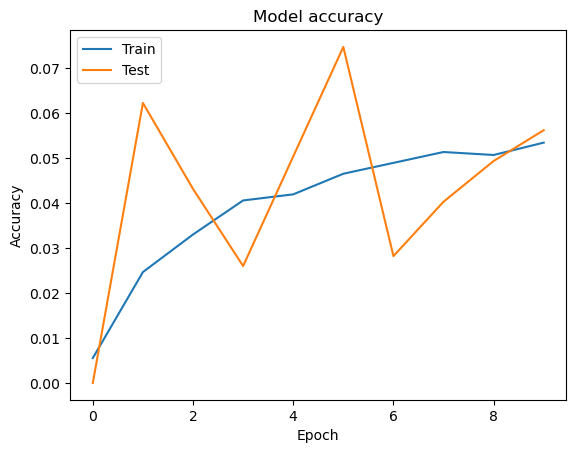

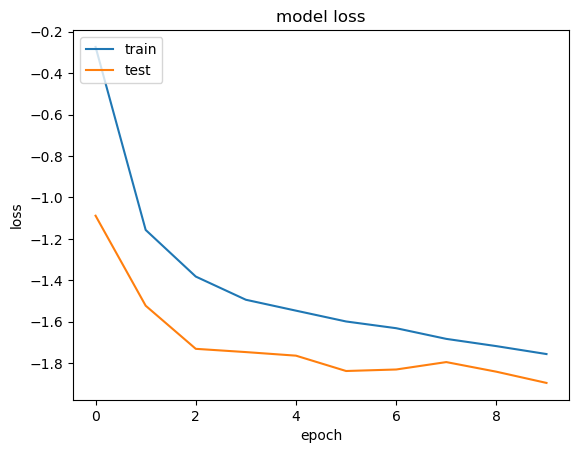

In [73]:
with open(model_path + '_history.csv', mode='rb') as f:
    history_model = pd.read_csv(f)

plt.plot(history_model.accuracy)
plt.plot(history_model.val_accuracy)

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_model.loss)
plt.plot(history_model.val_loss)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [3]:
def to_normal_form(comment):
    comment = comment.split() # –†–∞–∑–¥–µ–ª—è–µ–º –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –Ω–∞ —Å–ª–æ–≤–∞
    tokens = []
    for token in comment:
        if token and token not in stopwords:
            token = token.strip() # —É–¥–∞–ª—è–µ–º –ª–∏—à–Ω–∏–µ –ø—Ä–æ–±–µ–ª—ã –≤ —Ç–æ–∫–µ–Ω–µ
            token = pymorph.normal_forms(token)[0]
            tokens.append(token)
    return tokens

def clean_comment(comment):
    clean_pattern = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~‚Äî\"\-\n\‚Äú\‚Äù]+"
    comment = re.sub(clean_pattern, ' ', comment)
    clean_pattern = "[^–ê-–Ø–∞-—è\sA-Za-z]"
    comment = re.sub(clean_pattern, ' ', comment)
    return comment

In [5]:
comment = '"408909702014070784";"1386326644";"zunyzipobapi";"–ê –∫—Ç–æ-–Ω–∏–±—É–¥—å —Å–º–æ–∂–µ—Ç –ø–æ–¥—Å–∫–∞–∑–∞—Ç—å —Ö–æ—Ä–æ—à–∏—Ö –∫–Ω–∏–∂–µ–∫ –ø–æ –¥–∏–∑–∞–π–Ω—É –≤ –≤–µ–±–µ )) –Ω–µ —Å–µ–±–µ =)";"1";"0";"0";"0";"285";"100";"77";"0"'
comment = clean_comment(comment)
comment = to_normal_form(comment)
print(comment)

['–∞', '—Å–º–æ—á—å', '–ø–æ–¥—Å–∫–∞–∑–∞—Ç—å', '—Ö–æ—Ä–æ—à–∏–π', '–∫–Ω–∏–∂–∫–∞', '–¥–∏–∑–∞–π–Ω', '–≤–µ–±']
